In [ ]:
import datetime
from datetime import time, timedelta
import warnings
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

warnings.filterwarnings('ignore')

In [ ]:
with open('/content/drive/MyDrive/PROJECT    COMPLEX/data_1.pkl', 'rb') as f:
    data_1 = pickle.load(f)

data_1.keys()

dict_keys(['calls_clear', 'contacts_clear', 'deals_clear', 'spend_clear'])

In [ ]:
calls_clear, contacts_clear, deals_clear, spend_clear  = data_1.values()

# Вспомогательные функции и расчеты для анализа

In [ ]:
class InfoDataSet:
    def __init__(self, name, data):
        self.name = name
        self.data = data

    def pivot_info(self): # сводная описательная таблица датасета
        print('Name of the data: ', self.name)

        type_values = pd.Series({column: self.data[column].dtypes for column in self.data.columns})
        unique_values = pd.Series({column: self.data[column].unique() for column in self.data.columns})
        pivot_info = pd.DataFrame({'count': self.data.count(),
                                       'null': self.data.isnull().sum(),
                                       'unique': self.data.nunique(),
                                       'type': type_values,
                                       'unique_values': unique_values
                                       })

        object_types = {}
        for column in self.data.select_dtypes(include='object').columns:
          unique_types = self.data[column].apply(lambda x: type(x) if x is not None else float).unique()
          object_types[column] = [i for i in unique_types]
        pivot_info['object_types'] = pivot_info.index.map(lambda col: object_types.get(col, None))

        pivot_info = pivot_info[['count', 'null', 'type', 'object_types', 'unique', 'unique_values']]

        print(f'Shape of the data: {self.data.shape}')
        return pivot_info


# dataset = InfoDataSet("////", data)
# dataset.pivot_describe()
#

## расчет фактически полученной оплаты за курсы

добавляем в таблицу Deals столбец **AOV_i** - средняя стоимость обучения в месяц (формула от учителя по продуктовой аналитики):

(InAmountPaid cleaned + (OfTotAmount cleaned - InAmountPaid cleaned)/(Course duration - 1)*(Months of study - 1)) / Months of study

(предоплата + (общая стоимость курса - предоплата)/(длительность курса - 1)*(кол-во месяцев проучившись - 1)) / количество месяцев проучившись

In [ ]:
# добавляем столбец AOV_i
deals_clear['AOV_i'] = ((deals_clear['InAmountPaid cleaned'] +
                        (deals_clear['OfTotAmount cleaned'] -
                         deals_clear['InAmountPaid cleaned']) /
                        (deals_clear['Course duration'] - 1) *
                        (deals_clear['Months of study'] - 1)) /
                        deals_clear['Months of study'])

# deals_clear[deals_clear['Stage'] == "Payment Done"].head(1)

добавляем столбец R_i - сколько фактически школа получила денег от клиента

AOV_i * Months of study


средняя стоимость обучения в месяц * сколько месяцев проучился

In [ ]:
deals_clear['R_i'] = deals_clear['AOV_i'] * deals_clear['Months of study']

# deals_clear[(deals_clear['Stage'] == "Payment Done") & (deals_clear['Months of study']== 3)].head()

# Обзор исходных данных

In [ ]:
info_contacts = InfoDataSet("Contacts_info очищенная", contacts_clear)
display(info_contacts.pivot_info())

Name of the data:  Contacts_info очищенная
Shape of the data: (18536, 4)


,count,null,type,object_types,unique,unique_values
Id,18536,0,object,[<class 'str'>],18536,"[5805028000000872003, 5805028000000907006, 580..."
Contact Owner Name,18536,0,object,[<class 'str'>],27,"[Charlie Davis, Bob Brown, Nina Scott, Alice J..."
Created Time,18536,0,datetime64[ns],None,17918,"[2023-07-03 11:31:00, 2023-07-03 05:44:00, 202..."
Modified Time,18536,0,datetime64[ns],None,16578,"[2024-05-21 10:23:00, 2023-12-29 15:20:00, 202..."


In [ ]:
info_calls = InfoDataSet("Calls_info очищенная", calls_clear)
pivot_info_calls = info_calls.pivot_info()
display(pivot_info_calls)

Name of the data:  Calls_info очищенная
Shape of the data: (95785, 11)


,count,null,type,object_types,unique,unique_values
Id,95785,0,object,[<class 'str'>],95785,"[5805028000000879006, 5805028000000870005, 580..."
Call Start Time,95785,0,datetime64[ns],None,68438,"[2023-07-03 13:06:00, 2023-07-03 13:08:00, 202..."
Call Owner Name,95785,0,object,[<class 'str'>],33,"[Jane Smith, John Doe, Alice Johnson, Bob Brow..."
CONTACTID,91858,3927,object,"[<class 'float'>, <class 'str'>]",15214,"[nan, 5805028000000645014, 5805028000000872003..."
Call Type,95785,0,object,[<class 'str'>],3,"[Outbound, Missed, Inbound]"
Call Duration (in seconds),95785,0,int64,None,2619,"[0, 40, 20, 9, 5, 13, 33, 7, 884, 101, 4, 10, ..."
Call Status,95785,0,object,[<class 'str'>],11,"[Unattended Dialled, Attended Dialled, Missed,..."
Outgoing Call Status,86793,8992,object,"[<class 'str'>, <class 'float'>]",4,"[Completed, nan, Cancelled, Overdue, Scheduled]"
Scheduled in CRM,95785,0,int64,None,2,"[0, 1]"
Flag_Call Duration (in seconds),95785,0,int64,None,2,"[0, 1]"


In [ ]:
info_deals_1 = InfoDataSet("Deals_info очищенная", deals_clear)
pivot_info_deals = info_deals_1.pivot_info()
display(pivot_info_deals)

Name of the data:  Deals_info очищенная
Shape of the data: (19609, 27)


,count,null,type,object_types,unique,unique_values
Id,19609,0,object,[<class 'str'>],19609,"[5805028000056864695, 5805028000056859489, 580..."
Deal Owner Name,19609,0,object,[<class 'str'>],28,"[Ben Hall, Ulysses Adams, Eva Kent, Paula Unde..."
Closing Date,13026,6583,datetime64[ns],None,391,"[NaT, 2024-06-21 00:00:00, 2024-06-20 00:00:00..."
Quality,19609,0,object,[<class 'str'>],6,"[Unknown, D - Non Target, E - Non Qualified, B..."
Stage,19609,0,object,[<class 'str'>],13,"[New Lead, Lost, Need a consultation, Need To ..."
Lost Reason,14235,5374,object,"[<class 'float'>, <class 'str'>]",20,"[nan, Non target, Invalid number, Inadequate, ..."
Page,19609,0,object,[<class 'str'>],31,"[/eng/test, /at-eng, /eng, eng/digital-marketi..."
Campaign,19609,0,object,[<class 'str'>],151,"[03.07.23women, Unknown, engwien_AT, 04.07.23r..."
Content,19609,0,object,[<class 'str'>],180,"[v16, Unknown, b1-at, bloggersvideo14com, webs..."
Term,19609,0,object,[<class 'str'>],215,"[women, Unknown, 21_06_2024, recentlymoved, Co..."


In [ ]:
info_spend_1 = InfoDataSet("Spend_info очищенная", spend_clear)
pivot_info_spend_1 = info_spend_1.pivot_info()
display(pivot_info_spend_1)

Name of the data:  Spend_info очищенная
Shape of the data: (14887, 8)


,count,null,type,object_types,unique,unique_values
Date,14887,0,datetime64[ns],None,355,"[2023-07-03 00:00:00, 2023-07-04 00:00:00, 202..."
Source,14887,0,object,[<class 'str'>],13,"[Google Ads, Facebook Ads, CRM, Bloggers, Yout..."
Campaign,14887,0,object,[<class 'str'>],51,"[gen_analyst_DE, performancemax_eng_DE, Unknow..."
Impressions,14887,0,int64,None,3996,"[6, 4, 0, 187, 61, 21, 303, 78, 35, 50, 25, 21..."
Spend,14887,0,float64,None,2854,"[0.0, 0.01, 3.3, 0.02, 0.58, 0.24, 5.29, 0.83,..."
Clicks,14887,0,int64,None,552,"[0, 1, 6, 12, 5, 48, 37, 2, 8, 15, 34, 43, 3, ..."
AdGroup,14887,0,object,[<class 'str'>],21,"[Unknown, women, wide, interest_programming, r..."
Ad,14887,0,object,[<class 'str'>],166,"[Unknown, b3, b1, b4, b2, v2, v1, b4com, b3com..."


# ***Part 3.1. Анализ временных рядов***

## *1. Проанализируйте ***тенденцию создания сделок*** с течением времени и их связь с звонками.*


Проведу группировку данных по времени создания сделок. В данных инфа ежедневная - тенденцию сложно увидеть визуально, поэтому группирую по неделям. Сразу группирую все данные, которые могут понадобиться для анализа

In [ ]:
deals_per_week = deals_clear.groupby(pd.Grouper(key='Created Time', freq='W')).size().reset_index(name='Total Deals Count')
calls_per_week = calls_clear.groupby(pd.Grouper(key='Call Start Time', freq='W')).size().reset_index(name='Calls Count')
contacts_per_week = contacts_clear.groupby(pd.Grouper(key='Created Time', freq='W')).size().reset_index(name='Сontacts Count')

# подсчет количества удачных = оплаченых сделок (Payment Done в Stage)
payment_deals = deals_clear[deals_clear['Stage'] == "Payment Done"]
successful_per_week_count = payment_deals.groupby(pd.Grouper(key='Created Time', freq='W')).size().reset_index(name='Successful Deals Count')

# подсчет общей суммы затрат на рекламу, количество показов рекламы и количество кликов по неделям
spend_per_week = spend_clear.groupby(pd.Grouper(key='Date', freq='W')).agg(Spend = ('Spend', 'sum'),
                                                                           Spend_avg = ('Spend', 'mean'),
                                                                           Impressions = ('Impressions', 'sum'),
                                                                           Clicks = ('Clicks', 'sum')
                                                                           ).reset_index()

# подсчет суммы удачных = оплаченых сделок (Payment Done в Stage)
successful_per_week_sum = payment_deals.groupby(pd.Grouper(key='Created Time', freq='W'))['R_i'] \
                                        .sum().reset_index(name='Real Amount')

In [ ]:
deals_per_week.set_index('Created Time', inplace=True)
calls_per_week.set_index('Call Start Time', inplace=True)
contacts_per_week.set_index('Created Time', inplace=True)
successful_per_week_count.set_index('Created Time', inplace=True)
spend_per_week.set_index('Date', inplace=True)
successful_per_week_sum.set_index('Created Time', inplace=True)

# Объединение через join
time_series_data = deals_per_week.join(calls_per_week) \
                                 .join(contacts_per_week) \
                                 .join(successful_per_week_count) \
                                 .join(spend_per_week) \
                                 .join(successful_per_week_sum).dropna()

time_series_data.index.name = 'Week'
time_series_data.rename(columns={'Created Time': 'Week'}, inplace=True)
time_series_data = time_series_data.reset_index()
# time_series_data['Week'] = pd.to_datetime(time_series_data['Week'])

In [ ]:
print(time_series_data.shape)
time_series_data.head(2)

(50, 10)


,Week,Total Deals Count,Calls Count,Сontacts Count,Successful Deals Count,Spend,Spend_avg,Impressions,Clicks,Real Amount
0,2023-07-09,51,147,63,2.0,615.32,4.048158,95725,2552,19350.0
1,2023-07-16,123,354,129,1.0,954.19,6.447230,253916,4728,4000.0


Оценим визуально есть ли **связь между количеством звонков, контактов, общим количеством заключенных сделок, а также числом успешных сделок**

In [ ]:
time_series_data['Week'] = pd.to_datetime(time_series_data['Week'])

custom_colors = ['#9aa255', '#415d3b', '#53df66', '#e4d933']

fig3_1_1 = px.scatter(time_series_data,
                    x='Week',
                    y=['Calls Count', 'Total Deals Count', 'Сontacts Count', 'Successful Deals Count'],
                    trendline = "ols",
                    labels={'variable': 'Count', 'Week': 'Week', 'value': 'Count'},
                    marginal_y = "box",
                    color_discrete_sequence=custom_colors
                    )

fig3_1_1.update_layout(title="Dynamics of the number of calls, contacts and deals by week",
                       title_x = 0.5,
                       title_font=dict(family="Georgia", size=20, color="black", weight="bold"),
                       xaxis=dict(title=dict(text="Week",font=dict(size=14,color="black", weight="bold"))),
                       yaxis=dict(title=dict(text="Count",font=dict(size=14,color="black", weight="bold")))
                       )

fig3_1_1.update_layout(showlegend=True,
                       legend=dict(orientation = "v", yanchor = "top", y = 0.95, x = 1, xanchor = "right", title=""),
                       legend_font=dict(family="Georgia", size=12, color="black", weight="bold")
                       )


fig3_1_1.update_layout(plot_bgcolor="white")



fig3_1_1.update_xaxes(showgrid=False)
fig3_1_1.update_yaxes(showgrid=False)

fig3_1_1.show()

между количеством установленных контактов и общим количеством заключенных сделок разница не очень большая, поэтому одно из них можно исключить. Из анализа - убираю количество установленных контактов Сontacts Count (контактов иногда меньше, чем сделок, возможно одни и теже люди заключают несколько контактов)

Визуально связь между количеством звонков, количеством заключенных сделок (особенно успешных сделок) слабая.

Посмотрим как **на количество заключенных сделок влияет количество показов рекламы и количество кликов**

In [ ]:
time_series_data['Week'] = pd.to_datetime(time_series_data['Week']).dt.date

fig3_1_2 = go.Figure(layout=dict(width=1100, height=600))

fig3_1_2.add_trace(go.Bar(x = time_series_data['Week'],
                     y = time_series_data['Impressions'],
                     name ='Impressions',
                     hovertext = [f"Week: {week}, Impressions: {value}" for week, value in zip(time_series_data['Week'], time_series_data['Impressions'])],
                     hoverinfo='text',
                     marker = dict(color= 'lightgreen',
                                   line=dict(color='black', width=2),
                                   opacity = 0.2),
                     yaxis='y2'
                     )
              )

fig3_1_2.add_trace(go.Scatter(x = time_series_data['Week'],
                         y = time_series_data['Clicks'],
                         mode ='lines+markers',
                         name ='Clicks',
                         hovertext = [f"Week: {week}, Clicks: {value}" for week, value in zip(time_series_data['Week'], time_series_data['Clicks'])],
                         hoverinfo='text',
                         line = dict(dash='dot', color = '#e4d933', width=5)))

fig3_1_2.add_trace(go.Scatter(x = time_series_data['Week'],
                         y = time_series_data['Calls Count'],
                         mode = 'lines+markers',
                         name = 'Calls Count',
                         hovertext = [f"Week: {week}, Calls Count: {value}" for week, value in zip(time_series_data['Week'], time_series_data['Calls Count'])],
                         hoverinfo='text',
                         line = dict(color = '#748c47')
                         )
              )

fig3_1_2.add_trace(go.Scatter(x = time_series_data['Week'],
                         y = time_series_data['Total Deals Count'],
                         mode = 'lines+markers',
                         name = 'Total Deals Count',
                         hovertext = [f"Week: {week}, Deals Count: {value}" for week, value in zip(time_series_data['Week'], time_series_data['Total Deals Count'])],
                         hoverinfo='text',
                         line = dict(dash='dot', color = '#334832', width=3))
              )

fig3_1_2.update_layout(title="Dynamics of Impressions, Clicks, Calls and Total Deals by week",
                       title_x = 0.5,
                       title_y = 1,
                       title_font=dict(family="Georgia", size=20, color="black", weight="bold"),
                       xaxis=dict(title=dict(text="Week", font=dict(size=14, color="black", weight="bold")),
                                  tickangle=45),
                       yaxis=dict(title=dict(text="Count (Calls, Deals, Clicks)",font=dict(size=14,color="black", weight="bold"))),
                       yaxis2=dict(title=dict(text="Impressions",font=dict(size=14,color="black", weight="bold")),
                                   overlaying='y',
                                   side='right',
                                   anchor='x')
                       )


fig3_1_2.update_layout(showlegend=True,
                       legend=dict(orientation = "v", yanchor = "top", xanchor = "center", y = 1.1, x = 0.14, title=""),
                       legend_font=dict(family="Georgia", size=12, color="black", weight="bold")
                       )


fig3_1_2.update_layout(plot_bgcolor="white")

fig3_1_2.update_xaxes(showgrid=False)
fig3_1_2.update_yaxes(showgrid=False)

fig3_1_2.show()

Между количеством показов рекламы и количеством кликов явно прослеживается четкая прямая зависимость. Но их связь с количеством звонков не всегда явная - иногда при снижении показов рекламы, количество звонков, наоборот, увеличивается (возможно люди не сразу реагируют на рекламу, так как принятие решения о приобритении продукта онлайн школы требует времени, поэтому во времени образуется отставание по звонкам). При этом количество показов рекламы и количество кликов слабо влияет на количество заключенных сделок.

  Дальше проанализируем **влияние расходов на рекламу на количество заключенных сделок, а также на сумму успешных сделок**

In [ ]:
fig1_3 = go.Figure(layout=dict(width=1100, height=600))

fig1_3.add_trace(go.Scatter(x=time_series_data['Week'],
                            y=time_series_data['Successful Deals Count'],
                            mode='lines+markers',
                            name='Successful Deals Count',
                            hovertext = [f"Week: {week}, Successful Deals: {value}" for week, value in zip(time_series_data['Week'], time_series_data['Successful Deals Count'])],
                            hoverinfo='text',
                            line = dict(color = '#5c7a41')
                            )
                  )


fig1_3.add_trace(go.Scatter(x=time_series_data['Week'],
                            y=time_series_data['Spend_avg'],
                            mode='lines+markers',
                            name='Ad Spend mean',
                            hovertext = [f"Week: {week}, Ad Spend: {value}" for week, value in zip(time_series_data['Week'], time_series_data['Spend'])],
                            hoverinfo='text',
                            line = dict(dash='dot', color = '#53df66', width=5)
                            )
                  )


fig1_3.add_trace(go.Scatter(x=time_series_data['Week'],
                            y=time_series_data['Real Amount'],
                            mode='lines+markers',
                            name='Real Amount',
                            yaxis='y2',
                            hovertext = [f"Week: {week}, Real Amount: {value}" for week, value in zip(time_series_data['Week'], time_series_data['Real Amount'])],
                            hoverinfo='text',
                            line = dict(dash='dot', color = '#e4d933', width=5)
                            )
                  )

fig1_3.update_layout(title="Dynamics of Deals, Ad Spend and Sum from Deals by week",
                     title_x = 0.5,
                     title_y = 1,
                     title_font=dict(family="Georgia", size=20, color="black", weight="bold"),

                     xaxis=dict(title=dict(text="Week", font=dict(size=14, color="black", weight="bold")),
                                tickangle=45),
                     yaxis=dict(title=dict(text="Count of Deals \ Ad Spend mean",font=dict(size=14,color="black", weight="bold"))),

                     yaxis2=dict(title=dict(text="Real Amount",font=dict(size=14,color="black", weight="bold")),
                                 overlaying='y',
                                 side='right',
                                 anchor='x'
                                 )
                     )

fig1_3.update_layout(showlegend=True,
                     legend=dict(orientation = "v", yanchor = "top", xanchor = "center", y = 1.1, x = 0.14, title=""),
                     legend_font=dict(family="Georgia", size=12, color="black", weight="bold"))


fig1_3.update_layout(plot_bgcolor="white")

fig1_3.update_xaxes(showgrid=False)
fig1_3.update_yaxes(showgrid=False)
fig1_3.show()

Увеличение расходов на рекламу не всегда приводит к увеличению дохода (особенно это заметно в последние периоды, где наблюдается обратная зависимость). Но при этом их увеличение способствует увеличению общего количества сделок.

Тенденции дохода от успешных сделок и их количества в целом совпадают



Более точно увидеть эту зависимость позволит корреляционная матрица.

In [ ]:
corr_matrix = time_series_data[['Impressions', 'Clicks', 'Spend', 'Сontacts Count', 'Calls Count', 'Total Deals Count',
       'Successful Deals Count', 'Real Amount']].corr()
corr_matrix_percent = round(corr_matrix * 100, 2)
corr_matrix_percent

,Impressions,Clicks,Spend,Сontacts Count,Calls Count,Total Deals Count,Successful Deals Count,Real Amount
Impressions,100.00,84.68,73.84,57.49,60.38,54.46,4.10,-16.44
Clicks,84.68,100.00,62.99,57.08,46.44,51.08,25.80,15.57
Spend,73.84,62.99,100.00,86.09,82.82,80.78,27.93,-9.55
Сontacts Count,57.49,57.08,86.09,100.00,82.73,94.83,57.98,17.80
Calls Count,60.38,46.44,82.82,82.73,100.00,79.30,43.89,-2.32
Total Deals Count,54.46,51.08,80.78,94.83,79.30,100.00,50.74,14.23
Successful Deals Count,4.10,25.80,27.93,57.98,43.89,50.74,100.00,81.10
Real Amount,-16.44,15.57,-9.55,17.80,-2.32,14.23,81.10,100.00


In [ ]:
fig1_4 = px.imshow(corr_matrix_percent,
                   text_auto=True,
                   color_continuous_scale=px.colors.sequential.speed,
                   aspect='auto',
                   #  zmin=-1
                   #  zmax=1
                   )

fig1_4.update_layout(title="Correlation Matrix of time series",
                     title_x = 0.5,
                     title_font=dict(family="Arial", size=24, color="black", weight='bold')
                     )

fig1_4.show()

Итак, количество Сontacts и Deals практически совпадает, поэтому и коэффициент корреляции очень высокий - 94,85%.

Общее количество сделок (Total Deals Count) во многом зависит от количества звонков (Calls Count - на 79,3%) и расходов на рекламу (Spend - 80,78%. Возможно более качественная реклама приводила к большему интересу к школе), средняя зависимость Total Deals Count от количества показов рекламы (Impressions - 54,46%) и кликов (Clicks - 51,08%). Получается, что много других факторов, влияющих на Total Deals Count, не учтены в этом анализе. Успешные сделки (их количество и сумма) уже формируются позже, соответственно, Total Deals Count от них не зависит, но влияет на их формирование - оказывает среднее влияние (коэффициент корреляции 45-50%).

Если посмотреть хронологию формирования показателей, то начинаем с количества показов рекламы и заканчиваем количеством и суммой успешных сделок. Между ними корреляция практически отсутствует. Получается, что при принятии решения о приобретении курсов, клиент руководствуется абсолютно другими параметрами (а не количеством показа рекламы), что вполне логично.




## *2. Изучите ***распределение времени закрытия сделок*** и продолжительность периода от создания до закрытия.*


для оценки продолжительности периода времени от момента создания сделки до ее закрытия необходимо знать эти даты, а также учитывать успешность сделки (она состоялась и получили оплату, или она сорвалась). Все необходимые данные содержаться в таблице deals_clear

In [ ]:
last_date_in_df = deals_clear['Created Time'].max()
# открытые сделки, которые оплачиваются и не закрываются
open_successful_deals = deals_clear[(deals_clear['Closing Date'].isna()) & (deals_clear['Stage'] == 'Payment Done')]

# их продолжительность (разница между последней датой и Created Time)
time_successful_opened_deals = (last_date_in_df - open_successful_deals['Created Time']).dt.days

time_successful_opened_deals.shape

(333,)

In [ ]:
# дополнительный столбец, в котором считаем промежуток времени между открытием и закрытием сделки
deals_clear['Time_to_Close'] = abs(deals_clear['Closing Date'] - deals_clear['Created Time']).dt.days

In [ ]:
# две переменные, в которых разделяем закрытые сделки на успешные (они начинали оплачиваться и закрылись - имеют Closing Date)
# и потерянные, по которым оплата вообще не производилась и они тоже уже закрылись
successful_closed_deals_time = deals_clear[deals_clear['Stage'] == 'Payment Done']['Time_to_Close'].dropna()
lost_deals_time = deals_clear[deals_clear['Stage'] == 'Lost']['Time_to_Close'].dropna()

successful_closed_deals_time.shape, lost_deals_time.shape

((509,), (12262,))

Рассчитываем основные статистические показатели по всем трем числовым переменным промежутка времени

In [ ]:
time_successful_opened_deals.max(), time_successful_opened_deals.min(), round(time_successful_opened_deals.mean(),0), time_successful_opened_deals.median()

(353, 6, np.float64(156.0), 161.0)

In [ ]:
successful_closed_deals_time.max(), successful_closed_deals_time.min(), round(successful_closed_deals_time.mean(),0), successful_closed_deals_time.median()

(304.0, 0.0, np.float64(33.0), 16.0)

In [ ]:
lost_deals_time.max(), lost_deals_time.min(), round(lost_deals_time.mean(),0), lost_deals_time.median()

(334.0, 0.0, np.float64(14.0), 3.0)

---------------------------------------- Successful opened Deals ----------------------------------------


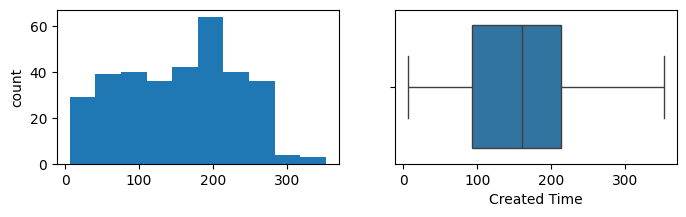

---------------------------------------- Successful closed Deals ----------------------------------------


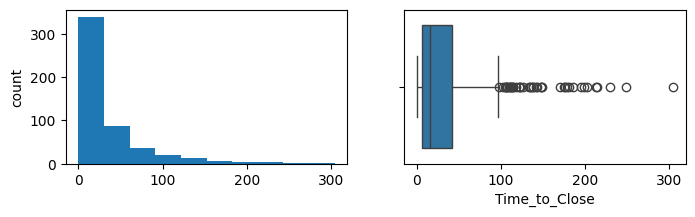

---------------------------------------- Lost Deals ----------------------------------------


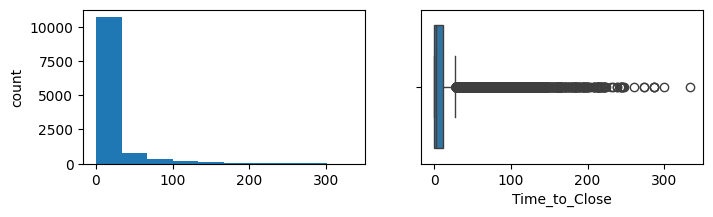

In [ ]:
variables = [time_successful_opened_deals, successful_closed_deals_time, lost_deals_time]
variable_names = ['Successful opened Deals', 'Successful closed Deals', 'Lost Deals']


for variable, name in zip(variables, variable_names):
    print("--" * 20, name, "--" * 20)
    plt.figure(figsize=(8, 2))
    plt.subplot(1, 2, 1)
    pd.Series(variable).hist(grid=False)
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=pd.Series(variable))
    plt.show()

Максимальная продолжительность обучения 11 месяцев (330 дней), но оплаченные сделки могут не закрываться и до двух лет - либо человек откладывает обучение, либо ошибка в CRM системе. И такой случай всего один (исходя из box-plot) - считаю это выбросом, реальность или ошибка - неважно, удаляю.

По закрытым сделкам - тоже не совсем понятно, почему долго не закрываются, но таких слчаев много, поэтому возможно это стандартная практика. Оставляю все значения

In [ ]:
hist_data = [successful_closed_deals_time, lost_deals_time, time_successful_opened_deals]
group_labels = ['Successful closed Deals', 'Lost Deals', 'Successful opened Deals']

fig2_1 = ff.create_distplot(
    hist_data,
    group_labels,
    show_hist=True,
    show_rug=True,
    bin_size=5,
    colors=['black', '#53df66', '#9aa255']
)



fig2_1.update_layout(title="Distribution of Time to Close for Successful and Lost Deals",
                     title_x = 0.5,
                     title_font=dict(family="Georgia", size=20, color="black", weight="bold"),
                     xaxis=dict(title=dict(text="Time to Close (days)",font=dict(size=14,color="black", weight="bold"))),
                     yaxis=dict(title=dict(text="Density",font=dict(size=14,color="black", weight="bold"))),
                     bargap=0.05
                   )

fig2_1.update_layout(showlegend=True,
                   legend=dict(orientation = "v", yanchor = "top", y = 0.95, x = 1, xanchor = "right", title=""),
                   legend_font=dict(family="Georgia", size=12, color="black", weight="bold"))


fig2_1.update_layout(plot_bgcolor="white")


fig2_1.update_xaxes(showgrid=False)
fig2_1.update_yaxes(showgrid=False)


fig2_1.show()

На графике есть потерянные сделки (***Lost Deals***) - они даже не оплачивались, закрываются как правило в течение первых 150 дней (возможно человек раздумывает учиться или нет, не даёт конкретный ответ, или менеджеры забывают закрыть сразу).

Есть успешные/оплаченные, но закрытые сделки (***Successful closed Deals***) - человек начинает оплачивать, но по какой-то причине сделка закрывается (возможно бросает обучение. Получается, что в первые 50 дней обучения очень высокая вероятность того, что человек может бросить курс).

И есть успешные/оплаченные, но ещё открытые сделки (***Successful opened Deals***) - их мало (333), по всей видимости это те, кто в исследуемый период ещё находится на обучении. Основная их масса не превышает 300 дней (максимальный период обучения 11 месяцев - примерно 335 дней). Таких сделок всего 2 - возможно по какой-то причине не окончили обучение

Не хватает информации о самом датасете, если предположения верные, то можно высчитать сумму потерь при досрочном закрытии сделок


In [ ]:
count_over_335 = (time_successful_opened_deals > 335).sum()
count_over_335

np.int64(2)

# ***Part 3.2. Анализ эффективности кампаний***

## *1. Сравните ***эффективность различных кампаний*** с точки зрения генерации лидов и коэффициента конверсии.*

Группирую по Campaign, считаю количество Lead (в качестве leads принимаю количество Contact Name в Deals - наиболее качественные leads, которые пошли на сделку), и количество наших клиентов (Customers) - успешных сделок (оплаченных - Payment Done в Stage).

Считаю конверсию по каждой кампании. Но убираю те компании, где Lead меньше 100, а также те, которые нам не известны Unknown (если они неизвестны, то не факт, что они из одной компании, а также неизвестно, какая кампания лучше), и сортирую по убыванию конверсии.

In [ ]:
campaign_deals = deals_clear.groupby('Campaign').agg({'Contact Name': 'count', \
                                                     'Stage': lambda x: (x == 'Payment Done').sum()}).reset_index()
campaign_deals.rename(columns={'Contact Name': 'Leads Deals', 'Stage': 'Customers'}, inplace=True)
campaign_deals['Сonversion'] = round(campaign_deals['Customers'] / campaign_deals['Leads Deals'] * 100, 2)

campaign_eff = campaign_deals[campaign_deals['Leads Deals'] >= 100]
campaign_eff = campaign_eff[campaign_eff['Campaign'] != 'Unknown']
campaign_eff = campaign_eff.sort_values(by='Сonversion', ascending=False)

In [ ]:
top_20 = campaign_eff.head(30)

In [ ]:
fig3_2_1 = px.scatter(top_20,
                      x='Campaign',
                      y='Сonversion',
                      size='Customers',
                      size_max=40,
                      labels={'Campaign': 'Campaign ',
                              'Leads Deals': 'Leads Deals ',
                              'Customers': 'Customers ',
                              'Сonversion': 'Сonversion % '},
                      hover_data=['Campaign', 'Leads Deals', 'Customers', 'Сonversion'],
                      color='Leads Deals',
                      color_continuous_scale=px.colors.sequential.speed[::-1]
                      )

fig3_2_1.update_layout(title="Conversion of companies (more 100 Leads)",
                       title_x = 0.5,
                       title_y = 1,
                       title_font=dict(family="Georgia", size=20, color="black", weight="bold"),

                       xaxis=dict(title=dict(text="Campaign", font=dict(size=14, color="black", weight="bold")),
                                  tickangle=45),
                       yaxis=dict(title=dict(text="Сonversion %",font=dict(size=14,color="black", weight="bold"))),
                       )


fig3_2_1.update_layout(showlegend=True,
                       legend=dict(orientation = "v", yanchor = "top", xanchor = "center", y = 1.1, x = 0.14, title=""),
                       legend_font=dict(family="Georgia", size=10, color="black", weight="bold"))


fig3_2_1.update_layout(plot_bgcolor="white")

fig3_2_1.update_xaxes(showgrid=False)
fig3_2_1.update_yaxes(showgrid=False)

fig3_2_1.show()

Чем больше размер точки, тем больше успешных сделок было получено по результатам кампании. И чем светлее, тем больше leads привлекла кампания.
Поскольку размер точки зависит от количества клиентов, то есть кампании, где было больше 100 лидов, но они не привлекли ни одного клиента, поэтому точка отсутствует - это наименее эффективные кампании.

Отдельно рассмотрю кампании, которые привлекли меньше 100 leads, и имели конверсию больше 0

In [ ]:
campaign_noneff = campaign_deals[campaign_deals['Leads Deals'] < 100]
campaign_noneff = campaign_noneff[campaign_noneff['Campaign'] != 'Unknown']
campaign_noneff = campaign_noneff.sort_values(by='Сonversion', ascending=False)
campaign_noneff = campaign_noneff[campaign_noneff['Сonversion'] > 0]
campaign_noneff.head(2)

,Campaign,Leads Deals,Customers,Сonversion
90,domain,1,1,100.0
137,web2311_DE,8,3,37.5


In [ ]:
fig3_2_2 = px.bar(campaign_noneff,
                  x='Campaign',
                  y='Сonversion',
                  labels={'Campaign': 'Campaign ',
                          'Leads Deals': 'Leads Deals ',
                          'Customers': 'Customers ',
                          'Сonversion': 'Сonversion % '},
                  hover_data=['Campaign', 'Leads Deals', 'Customers', 'Сonversion'],
                  color='Leads Deals',
                  color_continuous_scale= px.colors.sequential.speed[::-1]
                  )

fig3_2_2.update_layout(title="Conversion of unsuccessful/small сampaign (less 100 Leads and Conversion is more than 0)",
                       title_x = 0.5,
                       title_y = 1,
                       title_font=dict(family="Georgia", size=20, color="black", weight="bold"),
                       xaxis=dict(title=dict(text="Campaign", font=dict(size=14, color="black", weight="bold")),
                                  tickangle=45),
                       yaxis=dict(title=dict(text="Сonversion %",font=dict(size=14,color="black", weight="bold")))
                       )


fig3_2_2.update_layout(showlegend=True,
                       legend=dict(orientation = "v", yanchor = "top", xanchor = "center", y = 1.1, x = 0.14, title=""),
                       legend_font=dict(family="Georgia", size=10, color="black", weight="bold")
                       )


fig3_2_2.update_layout(plot_bgcolor="white")

fig3_2_2.update_xaxes(showgrid=False)
fig3_2_2.update_yaxes(showgrid=False)

fig3_2_2.show()

Результаты анализа данной группы кампаний считаю неинформативными, поскольку из-за незначительного количества результатов не отражают реальной конверсии кампании. По какой причине низкое количество leads или их полное отсутствие надо разбираться в каждом конкретном случае. Возможно кампания была только запущена и не успела принести свои плоды. Или она действительно неэффективна (при достаточно большом количестве показов не принесла результат).

Но ещё интересная зависимость - чем больше кампания привлекает лидов, тем ниже конверсия. То есть с увеличением количества данных, точность показателей усиливается.

## *2. Оцените ***эффективность различных маркетинговых источников*** (Source) в генерировании качественных сделок.*

Группирую по Source, считаю количество Lead (в качестве leads принимаю количество Contact Name в Deals - наиболее качественные leads, которые пошли на сделку), и количество наших клиентов (Customers) - успешных сделок (оплаченных - Payment Done в Stage).

Наибольшее количество клиентов дали такие Source как Facebook Ads, Google Ads и Organic, причем первые два принесли наибольшее количество Leads. Отсутствие точки на виде Source говорит о том, что из него не пришло ни одного клиента.

можно попробовать источник соединить с доходом

In [ ]:
source_deals = deals_clear.groupby(['Source', 'Quality']).agg({'Contact Name': 'count', \
                                                     'Stage': lambda x: (x == 'Payment Done').sum(), \
                                                                'R_i': 'sum'}).reset_index()
source_deals.rename(columns={'Contact Name': 'Leads Deals', 'Stage': 'Customers', 'R_i': 'Real Amount'}, inplace=True)
source_deals['Сonversion'] = round(source_deals['Customers'] / source_deals['Leads Deals'] * 100, 2)

source_deals = source_deals.sort_values(by=['Сonversion'], ascending=False)
source_deals

,Source,Quality,Leads Deals,Customers,Real Amount,Сonversion
37,SMM,A - High,37,19,68020.0,51.35
32,Partnership,B - Medium,2,1,2000.0,50.00
55,Webinar,A - High,15,7,17895.0,46.67
43,Telegram posts,A - High,16,7,28370.0,43.75
26,Organic,A - High,55,24,113845.0,43.64
...,...,...,...,...,...,...
54,Tiktok Ads,Unknown,251,0,0.0,0.00
59,Webinar,E - Non Qualified,97,0,0.0,0.00
60,Webinar,Unknown,6,0,0.0,0.00
65,Youtube Ads,E - Non Qualified,547,0,0.0,0.00


In [ ]:
custom_palette = ['#334832', '#5c7a41', '#9aa255', '#b8b368', '#f1ecc1', '#fefcda']
source_deals = source_deals.sort_values(by=['Leads Deals'], ascending= False)


fig3_2_3 = px.bar(source_deals,
                  x='Source',
                  y='Leads Deals',
                  color='Quality',
                  labels={'Source': 'Source ',
                          'Quality_Value': 'Count of Leads ',
                          'Quality': 'Quality Categories '},
                  color_discrete_sequence=custom_palette[::-1]
                  )

fig3_2_3.update_layout(title="Distribution of deals Quality by Source",
                       title_x = 0.5,
                       title_y = 1,
                       title_font=dict(family="Georgia", size=20, color="black", weight="bold"),
                       xaxis=dict(title=dict(text="Source", font=dict(size=14, color="black", weight="bold")),
                                  tickangle=45),
                       yaxis=dict(title=dict(text="Count of Leads",font=dict(size=14,color="black", weight="bold")))
                       )


fig3_2_3.update_layout(showlegend=True,
                       legend=dict(orientation = "v", yanchor = "top", xanchor = "center", y = 0.9, x = 0.9, title=""),
                       legend_font=dict(family="Georgia", size=12, color="black", weight="bold")
                       )


fig3_2_3.update_layout(plot_bgcolor="white")

fig3_2_3.update_xaxes(showgrid=False)
fig3_2_3.update_yaxes(showgrid=False)

fig3_2_3.show()

Во всех источниках очень высокая доля Unknown, E - Non Qualified и D - Non Target. В сравнении с ними C - Low, B - Medium и A - High незначительное количество.

Сортировка по Customers заложена ещё на этапе формирования таблицы. Высота по количеству Leads. Offline не привлек ни одного клиента, поэтому столбик отсутствует

Google Ads и Facebook Ads дали наибольшее количество клиентов и дохода. Offline не привлек ни одного клиента, поэтому столбик отсутствует






# ***Part 3.3. Анализ эффективности работы отдела продаж***

## *Оцените эффективность отдельных владельцев сделок и рекламных кампаний с точки зрения количества обработанных сделок, коэффициента конверсии и общей суммы продаж.*

In [ ]:
# выбираем необходиму информацию для анализа из таблицы deals_clear
owner_deals = deals_clear.groupby('Deal Owner Name').agg(Contact_Name = ('Contact Name', 'count'), \
                                                          Customers = ('Stage', lambda x: (x == 'Payment Done').sum()), \
                                                          median_SLA_hour = ('SLA_hours', 'median'),\
                                                          mean_SLA_hour = ('SLA_hours', 'mean'),\
                                                          Real_Amount = ('R_i', 'sum')).reset_index()

owner_deals.rename(columns={'Contact_Name': 'Leads Deals',  'median_SLA_hour': 'median SLA (hour)', 'mean_SLA_hour': 'mean SLA (hour)', 'Real_Amount': 'Real Amount'}, inplace=True)
owner_deals.shape


(28, 6)

In [ ]:
# выбираем необходиму информацию для анализа из таблицы calls_clear
owner_calls = calls_clear.groupby('Call Owner Name').agg(Count_Calls=('CONTACTID', 'count'), \
                                                         Leads_Calls=('CONTACTID', 'nunique'), \
                                                         Call_Duration_mean_in_seconds=('Call Duration (in seconds)', 'mean'), \
                                                         Call_Duration_median_in_seconds=('Call Duration (in seconds)', 'median'), \
                                                         Sum_Calls_in_seconds=('Call Duration (in seconds)', 'sum')).reset_index()

owner_calls.rename(columns={'Count_Calls': 'Count Calls', 'Leads_Calls': 'Leads Calls'}, inplace=True)
owner_calls['mean Calls (min)'] = round(owner_calls['Call_Duration_mean_in_seconds'] / 60, 2)
owner_calls['median Calls (min)'] = round(owner_calls['Call_Duration_median_in_seconds'] / 60, 2)
owner_calls['sum Calls (hour)'] = round(owner_calls['Sum_Calls_in_seconds'] / 3600, 2)

owner_calls = owner_calls.drop(columns=['Call_Duration_mean_in_seconds'])
owner_calls = owner_calls.drop(columns=['Call_Duration_median_in_seconds'])
owner_calls = owner_calls.drop(columns=['Sum_Calls_in_seconds'])

owner_calls.rename(columns={'Call Owner Name': 'Owner Name'}, inplace=True)

In [ ]:
# объединяем полученную информацию в одну таблицу. Присоединять буду левым джойном к owner_calls1

owner_calls.set_index('Owner Name', inplace=True)
owner_deals.set_index('Deal Owner Name', inplace=True)

owner_name_data = owner_calls.join(owner_deals, how='left')
owner_name_data = owner_name_data.reset_index()
# owner_name_data

In [ ]:
# owner_name_data

если изучить сводную таблицу owner_name_data по менеджерам из двух таблиц, то можно сделать вывод:

- не все менеджеры, которые есть в таблице calls имеют какие-то leads в таблице deals, поэтому не понятно как оценивать их влияние на формирование дохода

- есть менеджеры, у которых практически нет звонков в calls, но при этом они имеют много leads в deals - как они совершали сделки в таких количествах, не имея звонков - не понятно

Вывод - анализ работы менеджеров буду проводить только по deals.


Вначале выделяю менеджеров, которые обработали более 100 leads, сортирую по количеству привлеченных клиентов

In [ ]:
owner_deals = owner_deals[owner_deals['Leads Deals'] > 100]
owner_deals['Conversion'] = round((owner_deals['Customers'] / owner_deals['Leads Deals'] ) * 100, 2)
owner_deals = owner_deals.sort_values(by=['Customers'], ascending=False)
owner_deals = owner_deals.reset_index()
owner_deals.head()

,Deal Owner Name,Leads Deals,Customers,median SLA (hour),mean SLA (hour),Real Amount,Conversion
0,Charlie Davis,2910,149,4.62,36.349218,599455.0,5.12
1,Ulysses Adams,1930,126,4.64,21.328783,485320.0,6.53
2,Julia Nelson,2062,88,6.48,28.469112,409725.0,4.27
3,Paula Underwood,1699,86,4.79,18.257718,307605.0,5.06
4,Quincy Vincent,1736,63,5.70,21.602675,220980.0,3.63


In [ ]:
owner_deals = owner_deals.sort_values(by='Conversion', ascending=False)

fig3_3_1 = go.Figure(layout=dict(width=1100, height=600))

fig3_3_1.add_trace(go.Bar(x = owner_deals['Deal Owner Name'],
                     y = owner_deals['Leads Deals'],
                     name ='Leads Deals',
                     text=owner_deals['Customers'],
                     textposition='outside',
                     hovertext = [f"Deal Owner Name: {name}, Count: {value}" for name, value in zip(owner_deals['Deal Owner Name'], owner_deals['Leads Deals'])],
                     hoverinfo='text',
                     marker = dict(color = '#b8b368',
                                   line=dict(color='black', width=2),
                                   opacity = 0.5)
                     )
              )

fig3_3_1.add_trace(go.Scatter(x = owner_deals['Deal Owner Name'],
                         y = owner_deals['Conversion'],
                         mode ='markers',
                         name ='Conversion',
                         hovertext = [f"Deal Owner Name: {name}, Conversion %: {value}" for name, value in zip(owner_deals['Deal Owner Name'], owner_deals['Conversion'])],
                         hoverinfo='text',
                               yaxis='y2',
                         marker = dict(size = 10, color = '#334832')))

fig3_3_1.update_layout(title="Efficiency Analysis (Conversion) of the deals owners",
                        title_x = 0.5,
                        title_y = 1,
                        title_font=dict(family="Georgia", size=20, color="black", weight="bold"),
                        barmode='overlay',

                        xaxis=dict(title=dict(text="Owner Name", font=dict(size=14, color="black", weight="bold")),
                                   tickangle=45),
                        yaxis=dict(title=dict(text="Leads Deals", font=dict(size=14,color="black", weight="bold"))),
                        yaxis2=dict(title=dict(text="Conversion",font=dict(size=14,color="black", weight="bold")),
                                    overlaying='y',
                                    side='right',
                                    anchor='x',
                                    range=[0, 35] )
                        )


fig3_3_1.update_layout(showlegend=True,
                        legend=dict(orientation = "v", yanchor = "top", xanchor = "center", y = 1.1, x = 0.9, title=""),
                        legend_font=dict(family="Georgia", size=12, color="black", weight="bold"))


fig3_3_1.update_layout(plot_bgcolor="white")

fig3_3_1.update_xaxes(showgrid=False)
fig3_3_1.update_yaxes(showgrid=False)

fig3_3_1.show()

Вопросы вызывают те менеджеры, у которых много leads, но при этом у них уровень конверсии ниже тех, у которых количество leads еще выше.

In [ ]:
owner_deals = owner_deals.sort_values(by='Conversion', ascending=False)

fig_3_3_2 = go.Figure(layout=dict(width=1100, height=600))

fig_3_3_2.add_trace(go.Bar(x = owner_deals['Deal Owner Name'],
                     y = owner_deals['Leads Deals'],
                     name ='Leads Deals',
                     hovertext = [f"Deal Owner Name: {name}, Count: {value}" for name, value in zip(owner_deals['Deal Owner Name'], owner_deals['Leads Deals'])],
                     hoverinfo='text',
                     marker = dict(color = '#b8b368',
                                   line=dict(color='black', width=2),
                                   opacity = 0.5)
                     )
              )

fig_3_3_2.add_trace(go.Bar(x = owner_deals['Deal Owner Name'],
                     y = owner_deals['Real Amount'],
                     name ='Real Amount',
                     hovertext = [f"Deal Owner Name: {name}, Sum: {value}" for name, value in zip(owner_deals['Deal Owner Name'], owner_deals['Real Amount'])],
                     hoverinfo='text',
                     marker = dict(color = '#a9eb9d',
                                   #line=dict(color='black', width=2),
                                   opacity = 0.5),
                      yaxis='y2'
                     )
              )

fig_3_3_2.update_layout(title="Efficiency Analysis (Real Amount) of the deals owners",
                     title_x = 0.5,
                     title_y = 1,
                     title_font=dict(family="Georgia", size=20, color="black", weight="bold"),
                        barmode='overlay',

                     xaxis=dict(title=dict(text="Owner Name", font=dict(size=14, color="black", weight="bold")),
                                tickangle=45),
                     yaxis=dict(title=dict(text="Leads Deals", font=dict(size=14,color="black", weight="bold"))),

                     yaxis2=dict(title=dict(text="Real Amount",font=dict(size=14,color="black", weight="bold")),
                                 overlaying='y',
                                 side='right',
                                 anchor='x'
                                 ))


fig_3_3_2.update_layout(showlegend=True,
                     legend=dict(orientation = "v", yanchor = "top", xanchor = "center", y = 1.1, x = 0.9, title=""),
                     legend_font=dict(family="Georgia", size=12, color="black", weight="bold"))


fig_3_3_2.update_layout(plot_bgcolor="white")

fig_3_3_2.update_xaxes(showgrid=False)
fig_3_3_2.update_yaxes(showgrid=False)

fig_3_3_2.show()

Вместо конверсии используем сумму реально полученного дохода. Не всегда более низкая конверсия свидетельствует о низкой дохожности работы менеджера

# ***Part 3.4. Анализ платежей и продуктов***

## *1. Изучите распределение типов оплаты и их влияние на успешность сделок.*

In [ ]:
deals_clear['Payment Type'].value_counts()

,count
Payment Type,
Recurring Payments,337
One Payment,132
Reservation,5


In [ ]:
payment_type_deals = deals_clear.groupby(['Payment Type', 'Stage']).agg(Count_Payment=('Contact Name', 'count'),
                                                             Payment_Done_Count=('Stage', lambda x: (x == 'Payment Done').sum()),
                                                             Other_Categories_Stage=('Stage', lambda x: (x != 'Payment Done').sum()),
                                                             Real_Amount=('R_i', 'sum')
                                                             ).reset_index()

payment_type_deals

,Payment Type,Stage,Count_Payment,Payment_Done_Count,Other_Categories_Stage,Real_Amount
0,One Payment,Call Delayed,2,0,2,0.0
1,One Payment,Lost,15,0,15,0.0
2,One Payment,Payment Done,110,110,0,311555.0
3,One Payment,Qualificated,3,0,3,0.0
4,One Payment,Waiting For Payment,2,0,2,0.0
5,Recurring Payments,Call Delayed,9,0,9,0.0
6,Recurring Payments,Lost,79,0,79,0.0
7,Recurring Payments,Payment Done,245,245,0,691310.0
8,Recurring Payments,Qualificated,2,0,2,0.0
9,Recurring Payments,Registered on Webinar,1,0,1,0.0


Оплата в рассрочку пользуется большей популярностью, но и потери при таком способе оплаты выше

In [ ]:
custom_palette = ['#334832', '#5c7a41', '#9aa255', '#b8b368', '#f1ecc1', '#fefcda']
#source_deals = source_deals.sort_values(by=['Leads Deals'], ascending= False)


fig4_1_1 = px.bar(payment_type_deals,
                  x='Payment Type',
                  y='Count_Payment',
                  color='Stage',
                  labels={'Payment Type': 'Payment Type ',
                          'Count_Payment': 'Count_Payment ',
                          'Stage': 'Quality Categories '},
                  color_discrete_sequence=custom_palette[::-1]
                  )

fig4_1_1.update_layout(title="Distribution of Stage by Payment Type",
                       title_x = 0.5,
                       title_y = 1,
                       title_font=dict(family="Georgia", size=20, color="black", weight="bold"),
                       xaxis=dict(title=dict(text="Payment Type", font=dict(size=14, color="black", weight="bold")),
                                  tickangle=45),
                       yaxis=dict(title=dict(text="Count of Payment",font=dict(size=14,color="black", weight="bold")))
                       )


fig4_1_1.update_layout(showlegend=True,
                       legend=dict(orientation = "v", yanchor = "top", xanchor = "center", y = 0.9, x = 0.9, title=""),
                       legend_font=dict(family="Georgia", size=12, color="black", weight="bold")
                       )


fig4_1_1.update_layout(plot_bgcolor="white")

fig4_1_1.update_xaxes(showgrid=False)
fig4_1_1.update_yaxes(showgrid=False)

fig4_1_1.show()

По факту два варианта оплаты - единоразовый платеж и рассрочка. Второй вариант более популярен, но при таких платежах большая доля потерянных сделок.

## *2. Проанализируйте популярность и успешность различных продуктов и типов обучения.*


In [ ]:
deals_clear['Product'].value_counts()

,count
Product,
Digital Marketing,1933
UX/UI Design,996
Web Developer,561


In [ ]:
deals_clear['Education Type'].value_counts()

,count
Education Type,
Morning,2819
Evening,396


In [ ]:
product = deals_clear.groupby(['Product', 'Education Type']).agg(Count_deals=('Contact Name', 'count'),
                                                                 Payment_Done_Count=('Stage', lambda x: (x == 'Payment Done').sum()),
                                                                 Real_Amount=('R_i', 'sum')
                                                                 ).reset_index()
product['Percent Root'] = (product['Payment_Done_Count'] / product['Payment_Done_Count'].sum()) * 100
product

,Product,Education Type,Count_deals,Payment_Done_Count,Real_Amount,Percent Root
0,Digital Marketing,Evening,245,112,276240.0,13.658537
1,Digital Marketing,Morning,1491,348,1900310.0,42.439024
2,UX/UI Design,Evening,150,57,122935.0,6.951220
3,UX/UI Design,Morning,787,168,804510.0,20.487805
4,Web Developer,Evening,1,0,0.0,0.000000
5,Web Developer,Morning,533,135,359580.0,16.463415


In [ ]:
fig4_2_1 = px.sunburst(
    product,
    path=['Product', 'Education Type'],
    values='Payment_Done_Count',
    color='Product',
    color_discrete_map={
        'Digital Marketing': '#E4D933',
        'UX/UI Design': '#C5E38B',
        'Web Developer': '#5C7A41'
    }
)

fig4_2_1.update_layout(
    title="Distribution of succesfull Deals by Product and Education Type",
    title_x=0.5,
    title_y=1,
    title_font=dict(family="Georgia", size=20, color="black", weight="bold")
)

fig4_2_1.update_layout(
    showlegend=True,
    legend=dict(
        orientation="v",
        yanchor="top",
        xanchor="center",
        y=0.9,
        x=0.9,
        title=""
    ),
    legend_font=dict(family="Georgia", size=12, color="black", weight="bold")
)

fig4_2_1.update_traces(
    marker=dict(line=dict(color='#334832', width=2)),
    textinfo='label+percent root',
    customdata=product['Percent Root'],
    hovertemplate='<b>%{label}</b><br>Value: %{value}'

)

fig4_2_1.show()

Только два курса имеют дневную и вечернюю форму обучения. Дневная более популярна. Наибольшее количество студентов обучается на курсе Digital Marketing (56%) - их в два раз больше, чем студентов на UX/UI Design (27%). Web Developer меньше всего (16%).

Более подробно структура продуктов онлайн школы представлена на дашборде (развитие продуктов во времени и динамика дохода по направлениям)

# ***Завершение***

Сохраняю данные для продуктовой аналитики

In [ ]:
df = {'calls_final': calls_clear, 'contacts_final': contacts_clear, 'deals_final': deals_clear, 'spend_final': spend_clear}

with open('data_2.pkl', 'wb') as f:
    pickle.dump(df, f)

In [ ]:
with open('data_2.pkl', 'rb') as f:
    data_2 = pickle.load(f)

In [ ]:
data_2.keys()

dict_keys(['calls_final', 'contacts_final', 'deals_final', 'spend_final'])

In [ ]:
calls_final, contacts_final, deals_final, spend_final  = data_2.values()

Сохраняю данные для дашборда

In [ ]:
# calls_clear.to_csv('calls_final.csv')
# contacts_clear.to_csv('contacts_final.csv')
# deals_clear.to_csv('deals_final.csv')
# spend_clear.to_csv('spend_final.csv')

In [ ]:
calls_clear.to_excel('calls_final.xlsx')
contacts_clear.to_excel('contacts_final.xlsx')
deals_clear.to_excel('deals_final.xlsx')
spend_clear.to_excel('spend_final.xlsx')